✅ Font 'Helvetica' loaded successfully.
✅ Figure saved as: blogfeedback_mean_x0_rmse_coverage_width_scatter_only.pdf


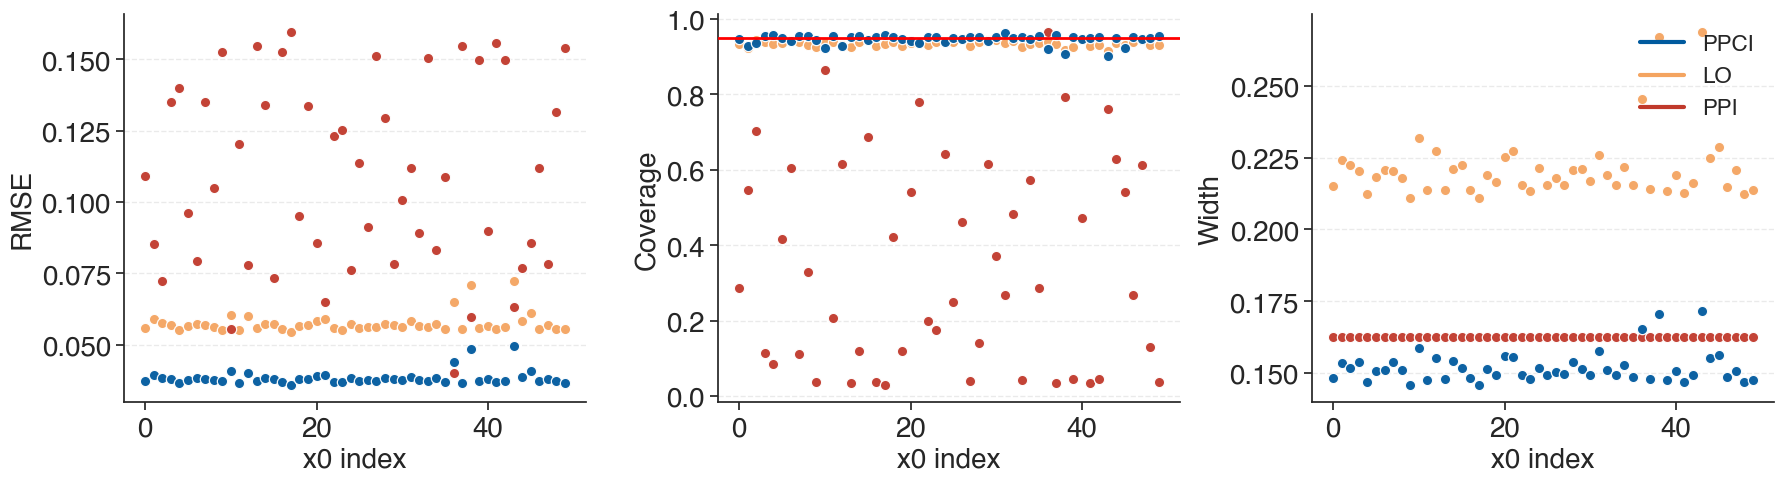

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import os
import numpy as np
from matplotlib.lines import Line2D

# ==========================================
# 0. Font & plotting style configuration (force Helvetica)
# ==========================================
FONT_SIZE = 20
font_path = '/home/ysui8/yangsuienv/Helvetica.ttf'
custom_font_name = "Helvetica"  # Assume loaded successfully

if os.path.exists(font_path):
    try:
        fm.fontManager.addfont(font_path)
        prop = fm.FontProperties(fname=font_path)
        if prop.get_name() != 'Helvetica':
            raise ValueError("Loaded font name mismatch")
        print(f"✅ Font 'Helvetica' loaded successfully.")
    except Exception as e:
        raise FileNotFoundError(
            f"❌ Unable to load Helvetica font file '{font_path}'. Please ensure the path is correct and the file is valid."
        )
else:
    raise FileNotFoundError(f"❌ Helvetica font file '{font_path}' not found. Please check the path.")

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = [custom_font_name]
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = custom_font_name
mpl.rcParams['mathtext.it'] = f'{custom_font_name}:italic'
mpl.rcParams['mathtext.bf'] = f'{custom_font_name}:bold'

sns.set_theme(
    style="ticks",
    rc={
        "axes.grid": False,   # Disable global grid first; manually enable only horizontal grid later
        "font.sans-serif": [custom_font_name],
    },
)

# ==========================================
# 1. Read data: BlogFeedback results CSV
# ==========================================
filename = "./results/blogfeedback_ppci_all_x0_updated.csv"
df = pd.read_csv(filename)

required_cols = [
    "x0_index",
    "PPCI_theta_rmse", "PPCI_coverage", "PPCI_avg_ci_width",
    "LO_theta_rmse",   "LO_coverage",   "LO_avg_ci_width",
    "PPI_theta_rmse",  "PPI_coverage",  "PPI_avg_ci_width",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CSV is missing these columns: {missing}")

df["x0_index"] = df["x0_index"].astype(int)

# ==========================================
# 2. Convert to long format: Method × Metric
# ==========================================
plot_data = []
for _, row in df.iterrows():
    x0i = int(row["x0_index"])

    # PPCI
    plot_data += [
        {"X0": x0i, "Method": "PPCI", "Metric": "RMSE",     "Value": float(row["PPCI_theta_rmse"])},
        {"X0": x0i, "Method": "PPCI", "Metric": "Coverage", "Value": float(row["PPCI_coverage"])},
        {"X0": x0i, "Method": "PPCI", "Metric": "Width",    "Value": float(row["PPCI_avg_ci_width"])},
    ]
    # LO
    plot_data += [
        {"X0": x0i, "Method": "LO", "Metric": "RMSE",     "Value": float(row["LO_theta_rmse"])},
        {"X0": x0i, "Method": "LO", "Metric": "Coverage", "Value": float(row["LO_coverage"])},
        {"X0": x0i, "Method": "LO", "Metric": "Width",    "Value": float(row["LO_avg_ci_width"])},
    ]
    # PPI
    plot_data += [
        {"X0": x0i, "Method": "PPI", "Metric": "RMSE",     "Value": float(row["PPI_theta_rmse"])},
        {"X0": x0i, "Method": "PPI", "Metric": "Coverage", "Value": float(row["PPI_coverage"])},
        {"X0": x0i, "Method": "PPI", "Metric": "Width",    "Value": float(row["PPI_avg_ci_width"])},
    ]

df_long = pd.DataFrame(plot_data)

# ==========================================
# 3. Colors & plotting order (keep consistent)
#   ✅ Update: no longer need smooth_line / connecting lines
# ==========================================
palette = {
    "PPCI": "#005a9e",
    "LO":   "#f4a460",
    "PPI":  "#c0392b",
}

methods_plot = ["LO", "PPI", "PPCI"]      # Draw LO first, then PPI, and PPCI last (PPCI points on top)
methods_legend = ["PPCI", "LO", "PPI"]

zorder_scatter = {"LO": 4, "PPI": 5, "PPCI": 6}

metrics = ["RMSE", "Coverage", "Width"]

# ==========================================
# 4. 1×3 panels: RMSE / Coverage / Width
#   ✅ Update: scatter only, no lines connecting points
# ==========================================
fig, axes = plt.subplots(
    1, 3,
    figsize=(18, 5),
    sharex=False,
    sharey=False
)

for c, metric in enumerate(metrics):
    ax = axes[c]
    sub_metric = df_long[df_long["Metric"] == metric]

    for method in methods_plot:
        sub = sub_metric[sub_metric["Method"] == method].copy()
        if sub.empty:
            continue

        sub = sub.sort_values("X0")
        x = sub["X0"].values
        y = sub["Value"].values

        # ✅ Scatter only
        ax.scatter(
            x, y,
            color=palette[method],
            marker="o",
            s=55,
            alpha=0.95,
            edgecolors="white",
            linewidths=0.9,
            zorder=zorder_scatter[method],
        )

    # Coverage red line at 0.95
    if metric == "Coverage":
        ax.axhline(
            0.95,
            color="red",
            linestyle="-",
            linewidth=2,
            zorder=10,
        )

    ax.set_ylabel(metric, fontsize=FONT_SIZE)
    ax.set_xlabel("x0 index", fontsize=FONT_SIZE)
    ax.tick_params(axis='both', labelsize=FONT_SIZE)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname(custom_font_name)

# ==========================================
# 5. Axis styling: keep only x/y spines + horizontal dashed gridlines only
# ==========================================
for ax in axes.flat:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)

    ax.set_axisbelow(True)
    ax.grid(False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.4)
    ax.xaxis.grid(False)

# ==========================================
# 6. Legend: place it in the third panel (Width), upper right
# ==========================================
method_handles = [
    Line2D([0], [0], color=palette[m], linewidth=3, label=m)
    for m in methods_legend
]

axes[2].legend(
    handles=method_handles,
    loc="upper right",
    fontsize=FONT_SIZE-4,
    frameon=False,
)

plt.tight_layout()
output_file = "blogfeedback_mean_x0_rmse_coverage_width_scatter_only.pdf"
plt.savefig(output_file, bbox_inches='tight', dpi=400)
print(f"✅ Figure saved as: {output_file}")
plt.show()
